In [27]:
import pandas as pd
import iris
import xarray as xr
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from eofs.multivariate.standard import MultivariateEof

In [2]:
# "era", "ncep" or "jra"
rea_selection = "era"

# TODO maybe choose variable combination for validation later in this dict
rea_info = {
    "era": {'path':'C:/Users/Aspire_NB/Desktop/era5_data/small_era5_daily.nc',
            'vars':['r', 'q']},
}


try:
    ds_rea = xr.open_mfdataset(rea_info[rea_selection]['path'], decode_cf=True)
except KeyError:
    print("Choose a valid reanalysis from these options: {}".format(', '.join(rea_info.keys())))
    raise
except:
    print("Unexpected error")
    raise

print ('hallo')

hallo


In [3]:
# Prepare ERA   -------------------------------------------------------------------------------------
if rea_selection == 'era':
    ds_rea = xr.open_mfdataset("C:/Users/Aspire_NB/Desktop/era5_data/small_era5_daily.nc", decode_cf=True).chunk({'time':-1})
    ds_rea = ds_rea.rename({'latitude': 'lat', 'longitude': 'lon'})
pass

In [4]:
def calc_normalized_anomalies(ds_prep, window_size=21):
    """
    This method prepares the input Dataset. It calculates the normalized anomalies with means
    and std calculated with a centered window of size window_size
    """
    

    # Resample with mean over data if temporal resolution is higher than daily (Lower resolution not supported here)
    if pd.infer_freq(ds_prep.time.data) not in 'D':
        ds_prep = ds_prep.resample(time='1D').mean()
        ds_prep = ds_prep.chunk({'time':-1})

    # calculates the climatology and the standard deviation for further anomaly calculation
    ds_prep_roll = ds_prep.rolling(time=window_size, center=True).construct('window_dim') # creates the rolling window as a new dimension

    # mean after construct without dropna: first and last windows are considered, even if there are timesteps with missing values
    ds_prep_clim = ds_prep_roll.groupby('time.dayofyear').mean(dim=['window_dim','time'])

    # calculate standard deviation (dayofyear std) for rolling window over Target Day ± 10days (pool)
    ds_prep_std = ds_prep_roll.groupby('time.dayofyear').std(dim=xr.ALL_DIMS) # Calculates the std for dayofyear of TD + pool, shape(365,)

    # calculate daily normalized anomalies with mean and std from TD + pool
    ds_prep = ds_prep.groupby('time.dayofyear') - ds_prep_clim
    ds_rea = ds_prep.groupby('time.dayofyear') / ds_prep_std

    # Rechunking necessary after groupby
    ds_rea = ds_rea.chunk({'time': -1})

    return ds_rea

In [5]:
# Calculate normalized anomalies and construct rolled dimension
ds_rea = calc_normalized_anomalies(ds_rea)
ds_rea_roll = ds_rea.rolling(time=21, center=True).construct('window_dim')

C:\Users\Aspire_NB\Anaconda3\envs\Klimaenvironment\lib\site-packages\xarray\core\indexing.py:1195: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


In [6]:
ds_rea_roll

<xarray.Dataset>
Dimensions:    (lat: 3, lon: 9, time: 14610, window_dim: 21)
Coordinates:
  * lon        (lon) float32 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0
  * lat        (lat) float32 46.0 47.0 48.0
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    dayofyear  (time) int64 dask.array<shape=(14610,), chunksize=(14610,)>
Dimensions without coordinates: window_dim
Data variables:
    r          (time, lat, lon, window_dim) float32 dask.array<shape=(14610, 3, 9, 21), chunksize=(14610, 3, 9, 21)>
    q          (time, lat, lon, window_dim) float32 dask.array<shape=(14610, 3, 9, 21), chunksize=(14610, 3, 9, 21)>
    msl        (time, lat, lon, window_dim) float32 dask.array<shape=(14610, 3, 9, 21), chunksize=(14610, 3, 9, 21)>

In [7]:
ds_rea.msl

<xarray.DataArray 'msl' (time: 14610, lat: 3, lon: 9)>
dask.array<shape=(14610, 3, 9), dtype=float32, chunksize=(14610, 3, 9)>
Coordinates:
  * lon        (lon) float32 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0
  * lat        (lat) float32 46.0 47.0 48.0
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    dayofyear  (time) int64 dask.array<shape=(14610,), chunksize=(14610,)>

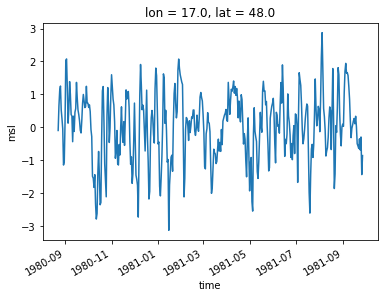

In [9]:
ds_rea.msl[600:1000,2,8].plot()

In [32]:
# Loop over dayofyear   ---------------------------------------------------------------------------------------------------------
for _, ds_test in ds_rea_roll.groupby("time.dayofyear"):

    # TODO
    ds_test = ds_test.rename({"time":"time_old"})
    #ds_test = ds_test.stack(time=('time_old', 'window_dim')).transpose('time_eof', 'lat', 'lon', 'nbnds')
    ds_test = ds_test.stack(time=('time_old', 'window_dim')).transpose('time', 'lat', 'lon')
    # Add attribute axis for EOF package to find new time dimension
    ds_test.coords['time'].attrs['axis'] = 'T'

    # Rename time dimension to avoid conflict if pcs are computed

    # Create an EOF solver to do the EOF analysis. Square-root of cosine of
    # latitude weights are applied before the computation of EOFs.
    # coslat = np.cos(np.deg2rad(z_djf.coords['latitude'].values)).clip(0., 1.)
    # wgts = np.sqrt(coslat)[..., np.newaxis]
    #solver = Eof(ds_test.pres.dropna('time'))
    
    msl = ds_test.msl.dropna('time').values
    r = ds_test.r.dropna('time').values
    q = ds_test.q.dropna('time').values
    
    
    msolver = MultivariateEof([msl, r, q])
    eofs_msl, eofs_r, eofs_q = msolver.eofs(neofs=5)
    pc_1 = msolver.pcs(npcs=5)


    break

In [33]:
pc_1

array([[-7.6112    ,  7.5103393 ,  1.8063563 , -0.16933985,  1.9539348 ],
       [ 1.6781744 ,  4.979671  ,  7.0775104 , -3.2057202 ,  0.62341744],
       [ 2.1571639 ,  4.180071  ,  6.724051  , -1.8531162 ,  0.873021  ],
       ...,
       [-4.2170763 , -3.647156  , -1.1113244 ,  2.5801528 , -3.2215955 ],
       [-3.987591  ,  0.09459088,  0.17606603,  2.0489905 ,  1.6145761 ],
       [-3.9929492 ,  0.40437537, -0.40290394, -3.418889  , -1.7197515 ]],
      dtype=float32)

In [34]:
eofs_msl

array([[[ 0.1143795 ,  0.11237804,  0.11399539,  0.11347608,
          0.11468748,  0.1182808 ,  0.12362572,  0.12391073,
          0.12344657],
        [ 0.11374832,  0.11211598,  0.1132941 ,  0.11656632,
          0.1160461 ,  0.11926754,  0.12350215,  0.12575233,
          0.12530822],
        [ 0.12735403,  0.1288682 ,  0.12987606,  0.1310866 ,
          0.1313444 ,  0.13121511,  0.13071138,  0.12871194,
          0.12657952]],

       [[-0.14369449, -0.13782531, -0.14093941, -0.14645986,
         -0.14998285, -0.14622732, -0.13990182, -0.13856916,
         -0.13903807],
        [-0.12505369, -0.12333157, -0.12347782, -0.12675561,
         -0.12591317, -0.13050127, -0.13107961, -0.13286756,
         -0.13375942],
        [-0.12571701, -0.1259286 , -0.12458824, -0.12529089,
         -0.12627216, -0.12668452, -0.12711783, -0.12603831,
         -0.12960385]],

       [[ 0.0059174 ,  0.01430979,  0.00959483, -0.00420775,
         -0.00956721, -0.00134814,  0.01456717,  0.01528709,
    

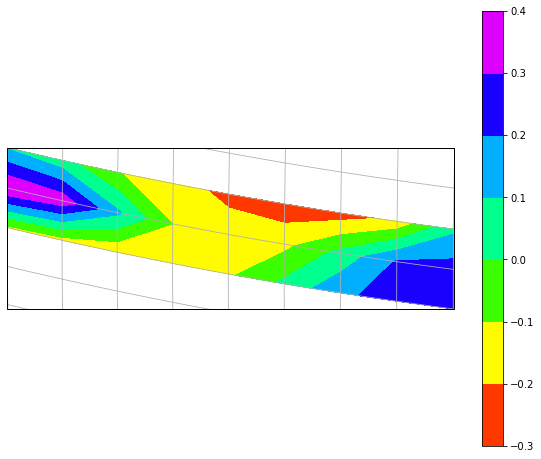

In [43]:
f=plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=18,central_latitude=47))
c = ax.contourf(eof.values[4,:,:],transform=ccrs.PlateCarree(),cmap='gist_rainbow')
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(c,ax=ax, orientation='vertical')

In [ ]:
##############Variate ohne multivariate EOFS##############

In [19]:
for _, ds_test in ds_rea_roll.groupby("time.dayofyear"):
    
    ds_test = ds_test.rename({"time":"time_old"})
    
    ds_test = ds_test.stack(time=('time_old','window_dim')).transpose('time','lat','lon')
    
    ds_test.coords['time'].attrs['axis'] = 'T'
    
    solver = Eof(ds_test.msl.dropna('time'))
    pc = solver.pcs(npcs=5)
    eof = solver.eofs(neofs=5)
    
    break

In [20]:
pc

<xarray.DataArray 'pcs' (time: 830, mode: 5)>
array([[-9.634356,  2.915024, -0.425043,  0.296549,  0.091663],
       [ 0.177711,  2.005744,  0.551741, -0.33295 , -0.107169],
       [ 0.601755,  0.921394,  0.78956 , -0.199486, -0.035982],
       ...,
       [-0.348386, -1.923733, -0.459791, -0.71113 ,  0.269419],
       [-2.827666, -0.310929,  0.179895, -0.142153, -0.011319],
       [-2.363908,  0.38524 , -0.361151, -0.121328, -0.065167]], dtype=float32)
Coordinates:
  * time        (time) MultiIndex
  - time_old    (time) datetime64[ns] 1979-01-01 1979-01-01 ... 1980-01-01
  - window_dim  (time) int64 10 11 12 13 14 15 16 17 ... 11 12 13 14 15 16 17 18
  * mode        (mode) int32 0 1 2 3 4
    dayofyear   (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1

In [21]:
eof

<xarray.DataArray 'eofs' (mode: 5, lat: 3, lon: 9)>
array([[[ 0.182572,  0.179246,  0.181829,  0.18178 ,  0.183815,  0.187652,
          0.193449,  0.193554,  0.192856],
        [ 0.185795,  0.183047,  0.182758,  0.185868,  0.184587,  0.187229,
          0.192355,  0.195162,  0.194616],
        [ 0.202102,  0.203761,  0.204275,  0.205114,  0.205114,  0.204317,
          0.203116,  0.199291,  0.19579 ]],

       [[-0.153887, -0.133789, -0.160502, -0.19988 , -0.213688, -0.211291,
         -0.193435, -0.199043, -0.215572],
        [ 0.302486,  0.275866,  0.168548,  0.087912,  0.042953, -0.096038,
         -0.133656, -0.169068, -0.182822],
        [ 0.309701,  0.296774,  0.269603,  0.222824,  0.185862,  0.126149,
          0.064872, -0.037378, -0.147735]],

       [[ 0.299913,  0.287988,  0.243241,  0.254836,  0.264204,  0.123492,
         -0.056759, -0.101105, -0.10358 ],
        [ 0.208604,  0.2452  ,  0.19945 ,  0.179137,  0.10175 , -0.004205,
         -0.144359, -0.211325, -0.210159],


In [22]:
#eofs_r

In [23]:
#eofs_q

In [24]:
lats = eof['lat'][:] 
lons = eof['lon'][:]

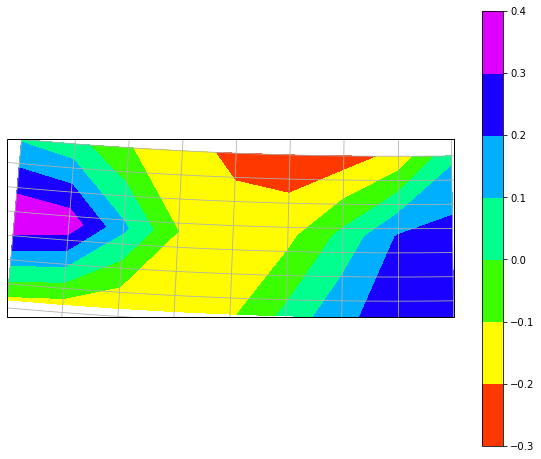

In [28]:
f=plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=16,central_latitude=47))
c = ax.contourf(lons,lats,eof.values[4,:,:],transform=ccrs.PlateCarree(),cmap='gist_rainbow')
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(c,ax=ax, orientation='vertical')

